In [1]:
import os
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom
from nilearn.image import resample_img

import pydra
from pydra.engine.specs import File, SpecInfo
from pydra.engine.core import Workflow
from pydra.engine.task import FunctionTask
# import pydra.tasks.ants as ants
import ants

from nilearn import plotting
import matplotlib.pyplot as plt

## 04/08/2024

In [3]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
mri_file = os.path.join(data_dir, "original_MRI.nii.gz")
fusi_file = os.path.join(data_dir, "Charmander_withouskull_withMB_3Dscan_4_angio3D.nii")
fusi_chunk_file1 = os.path.join(data_dir, "Grouper_3DAnigio_WithLu_0321_3Dscan_2.nii")
fusi_chunk_file2 = os.path.join(data_dir, "Zion_3Danigio_withLu_0321_2ndtry_3Dscan_5.nii")
output_dir = os.path.join(os.getcwd(), "output")

In [ ]:
mri_img = nib.load(mri_file)
mri_img.header.get_zooms()

In [ ]:
plotting.plot_anat(mri_file)

In [ ]:
fusi_img = nib.load(fusi_file)
fusi_img.header.get_zooms()

In [ ]:
plotting.plot_anat(fusi_file)

In [ ]:
fusi_chunk_data1 = nib.load(fusi_chunk_file1).get_fdata()
fusi_chunk_data1.shape

In [ ]:
fusi_chunk_img2 = nib.load(fusi_chunk_file2)
fusi_chunk_img2.header.get_zooms()

## 04/17/2024

In [4]:
import os
base_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(base_dir, "data")
output_dir = os.path.join(base_dir, "output")

In [ ]:

from nipype.interfaces.dcm2nii import Dcm2niix
converter = Dcm2niix()
# Set the parameters for the conversion
converter.inputs.source_dir = os.path.join (data_dir, 'Florian_MRI', 'DICOM')  # Update with the path to your DICOM folder
converter.inputs.compression = 5
converter.inputs.output_dir = os.path.join(output_dir, 'Florian_MRI_nifti')  # Update with your output path
converter.inputs.out_filename = '%p_%t'  # Format the output filenames

# Run the conversion
result = converter.run()


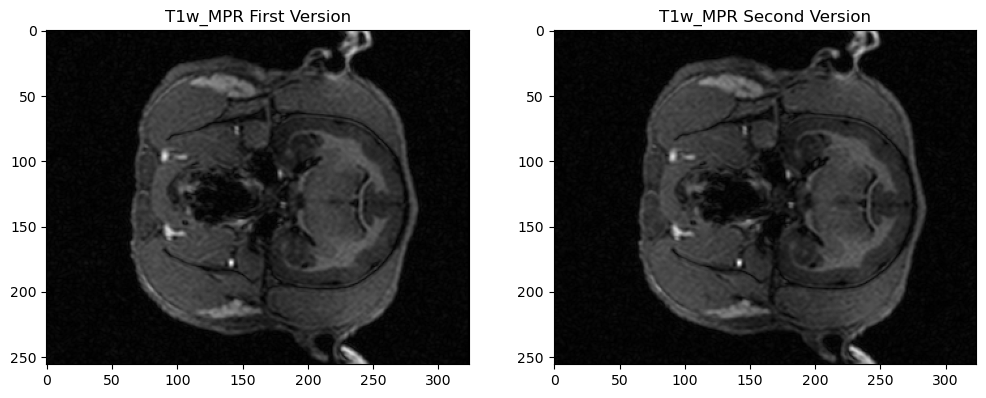

In [5]:
import nibabel as nib
import matplotlib.pyplot as plt

img_path1 = os.path.join(output_dir, 'Florian_MRI_nifti', 'T1w_MPR_20240405094408.nii.gz')
img_path2 = os.path.join(output_dir, 'Florian_MRI_nifti', 'T1w_MPR_20240405094408a.nii.gz')
# Load the images
img1 = nib.load(img_path1)
img2 = nib.load(img_path2)

# Convert to numpy arrays
data1 = img1.get_fdata()
data2 = img2.get_fdata()

# Display the middle slice of each image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(data1[:, :, data1.shape[2] // 2], cmap='gray')
plt.title('T1w_MPR First Version')
plt.subplot(1, 2, 2)
plt.imshow(data2[:, :, data2.shape[2] // 2], cmap='gray')
plt.title('T1w_MPR Second Version')
plt.show()


## Co-register two scans and then get the average

In [ ]:
import ants

img_path1 = os.path.join(output_dir, 'Florian_MRI_nifti', 'T1w_MPR_20240405094408.nii.gz')
img_path2 = os.path.join(output_dir, 'Florian_MRI_nifti', 'T1w_MPR_20240405094408a.nii.gz')

# Load the images
fixed_image = ants.image_read(img_path1)
moving_image = ants.image_read(img_path2)

# Run the registration (this is a simplified example; see ANTsPy documentation for all options)
registration = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform='SyN')

# Apply the transformation to the moving image
moving_transformed = ants.apply_transforms(fixed=fixed_image, moving=moving_image, transformlist=registration['fwdtransforms'])

# Average the fixed image and the transformed moving image
average_image_data = (fixed_image.numpy() + moving_transformed.numpy()) / 2.0
average_image = ants.from_numpy(average_image_data, origin=fixed_image.origin, spacing=fixed_image.spacing, direction=fixed_image.direction)

# Save the averaged image
# ants.image_write(average_image, 'averaged_marmoset_brain.nii')

In [ ]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(data1[:, :, data1.shape[2] // 2], cmap='gray')
plt.title('T1w_MPR First Version')
plt.subplot(1, 3, 2)
plt.imshow(data2[:, :, data2.shape[2] // 2], cmap='gray')
plt.title('T1w_MPR Second Version')
plt.subplot(1, 3, 3)
plt.imshow(average_image.numpy()[:, :, average_image.numpy().shape[2] // 2], cmap='gray')
plt.title('T1w_MPR Averaged')
plt.show()

In [ ]:
save_dir = os.path.join(output_dir, 'Florian_preproc')
ants.image_write(average_image, os.path.join(save_dir, 'T1w_MPR_averaged.nii.gz'))

In [ ]:
from nipype.interfaces.fsl import BET
import matplotlib.pyplot as plt
import nibabel as nib

# Load the MRI image for visual inspection
bet_dir = os.path.join(output_dir, 'Florian_preproc', 'bet2')
os.makedirs(bet_dir, exist_ok=True)

# Load the MRI image for visual inspection
mri_file = os.path.join(output_dir, 'Florian_MRI_nifti', 'T1w_MPR_20240405094408a.nii.gz')
mri_img = nib.load(mri_file)
mri_data = mri_img.get_fdata()

# Define a range of potential frac values
frac_values = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for frac in frac_values:
    # Set up BET for each frac value
    bet_out_file = os.path.join(bet_dir, f'T1w_MPR_brain_{frac}.nii.gz')
    bet_mask_file = os.path.join(bet_dir, f'T1w_MPR_brain_{frac}_mask.nii.gz')
    bet = BET(in_file=mri_file, out_file=bet_out_file, frac=frac, mask=True)
    
    # Run BET
    bet.run()
    
    # Load the output mask for visual inspection
    brain_mask_data = nib.load(bet_mask_file).get_fdata()

    # Verify dimensions and existence of the mask
    if mri_data.shape != brain_mask_data.shape:
        print(f"Dimension mismatch for frac={frac}: MRI data shape {mri_data.shape}, mask shape {brain_mask_data.shape}")
        continue

    # Display the middle slice of the brain extraction result
    plt.figure(figsize=(5, 5))
    slice_index = mri_data.shape[2] // 2
    plt.imshow(mri_data[:, :, slice_index], cmap='gray')
    plt.imshow(brain_mask_data[:, :, slice_index], alpha=0.5, cmap='Reds')
    plt.title(f'BET Result with frac = {frac}')
    plt.show()

In [ ]:
import numpy as np

In [ ]:
mri_img.shape

In [ ]:
np.unique(mri_img.get_fdata())

# 04/18/2024

In [7]:
import os
import ants
import numpy as np
import matplotlib.pyplot as plt

base_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(base_dir, "data")
output_dir = os.path.join(base_dir, "output")

## Bias field correction

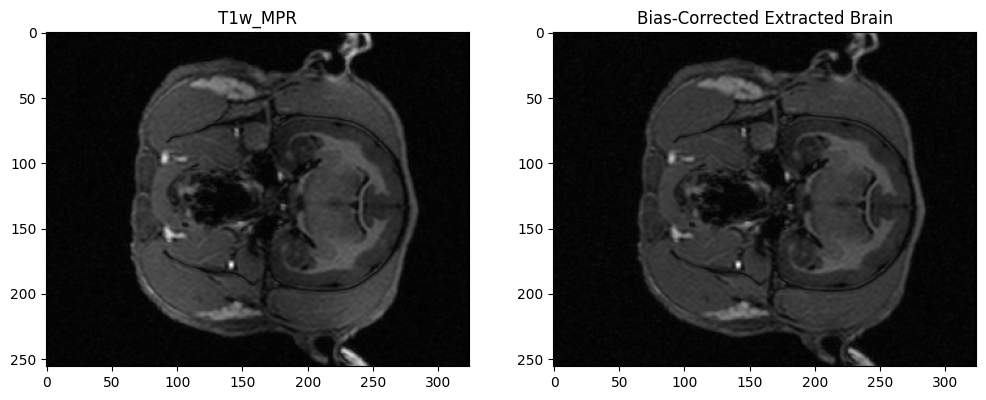

In [21]:
import ants

t1w_file = os.path.join(output_dir, 'Florian_preproc', 'T1w_MPR_averaged.nii.gz')

# Perform bias field correction
t1w_image = ants.image_read(t1w_file)
# corrected_image = ants.n4_bias_field_correction(t1w_image)

# Save the bias-corrected image
output_file = os.path.join(output_dir, 'Florian_preproc', 'bias_corrected_brain.nii.gz')
# ants.image_write(corrected_image, output_file)
corrected_image = ants.image_read(output_file)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(t1w_image.numpy()[:, :, t1w_image.shape[2] // 2], cmap='gray')
plt.title('T1w_MPR')
plt.subplot(1, 2, 2)
plt.imshow(corrected_image.numpy()[:, :, corrected_image.shape[2] // 2], cmap='gray')
plt.title('Bias-Corrected Extracted Brain')
plt.show()

## register corrected T1w to T2w template (resampling to T2w space)

In [ ]:
t1w_file = os.path.join(output_dir, 'Florian_MRI_nifti', 'T1w_MPR_20240405094408.nii.gz')
t1w_image = ants.image_read(t1w_file)
t2w_template_file = os.path.join(data_dir, 'template_T2w_brain.nii.gz')
t2w_template_image = ants.image_read(t2w_template_file)
t1w_image.shape, t2w_template_image.shape

In [ ]:
t1w_image.spacing, t2w_template_image.spacing

In [ ]:
img1 = nib.load(t1w_file).header.get_zooms()
img2 = nib.load(t2w_template_file).header.get_zooms()
img1, img2

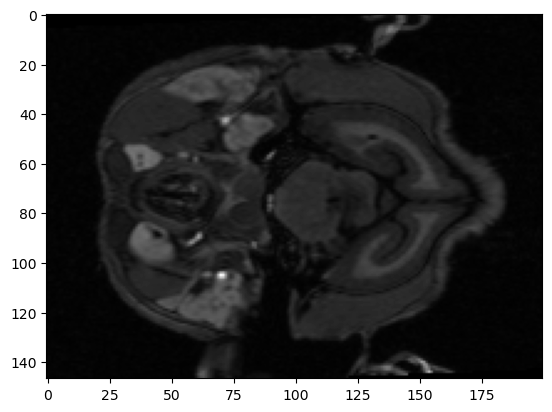

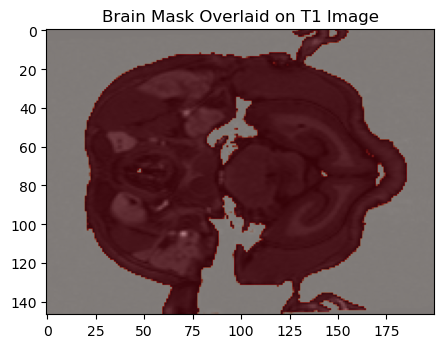

In [8]:
t1w_file = os.path.join(output_dir, 'Florian_preproc', 'bias_corrected_brain.nii.gz')
t1w_image = ants.image_read(t1w_file)
t2w_template_file = os.path.join(data_dir, 'template_T2w_brain.nii.gz')
t2w_template_image = ants.image_read(t2w_template_file)
mytx = ants.registration(fixed=t2w_template_image, moving=t1w_image, type_of_transform='SyN')
plt.imshow(mytx['warpedmovout'].numpy()[:, :, mytx['warpedmovout'].shape[2] // 2], cmap='gray')

image = mytx['warpedmovout']

# Create a mask of ones with the same shape as the image
full_image_mask = ants.image_clone(image)  # Clone the structure of the image
full_image_mask[:] = 1  # Set all values to 1 to create a full mask

segmentation = ants.atropos(a=image, m='[0.2,1x1x1]', c='[2,0]', 
                            i='kmeans[3]',  # Assuming 3-tissue segmentation
                            x=full_image_mask)  # Use the full image mask

# below assuming class 2 is GM and class 3 is WM
gm_mask = segmentation['probabilityimages'][1]
wm_mask = segmentation['probabilityimages'][2]

# Combine GM and WM to create a full brain mask
brain_mask = gm_mask + wm_mask

ants.image_write(image, os.path.join(output_dir, 'Florian_preproc', 'ants', 'extracted_corrected_T1w_brain.nii.gz'))
ants.image_write(brain_mask, os.path.join(output_dir, 'Florian_preproc', 'ants', 'brain_mask.nii.gz'))
ants.image_write(gm_mask, os.path.join(output_dir, 'Florian_preproc', 'ants', 'gm_mask.nii.gz'))
ants.image_write(wm_mask, os.path.join(output_dir, 'Florian_preproc', 'ants', 'wm_mask.nii.gz'))

slice_index = brain_mask.shape[2] // 2
plt.figure(figsize=(5, 5))
plt.imshow(image.numpy()[:,:,slice_index], cmap='gray')
plt.imshow(brain_mask.numpy()[:,:,slice_index], alpha=0.5, cmap='Reds')
plt.title('Brain Mask Overlaid on T1 Image')
plt.show()

In [ ]:
t1w_file = os.path.join(output_dir, 'Florian_MRI_nifti', 'T1w_MPR_20240405094408a.nii.gz')
t1w_image = ants.image_read(t1w_file)
t2w_template_file = os.path.join(data_dir, 'template_T2w_brain.nii.gz')
t2w_template_image = ants.image_read(t2w_template_file)
mytx = ants.registration(fixed=t2w_template_image, moving=t1w_image, type_of_transform='SyN')
plt.imshow(mytx['warpedmovout'].numpy()[:, :, mytx['warpedmovout'].shape[2] // 2], cmap='gray')

In [ ]:
t1w_file = os.path.join(output_dir, 'Florian_preproc', 'T1w_MPR_averaged.nii.gz')
t1w_image = ants.image_read(t1w_file)
t2w_template_file = os.path.join(data_dir, 'template_T2w_brain.nii.gz')
t2w_template_image = ants.image_read(t2w_template_file)
mytx = ants.registration(fixed=t2w_template_image, moving=t1w_image, type_of_transform='SyN')
plt.imshow(mytx['warpedmovout'].numpy()[:, :, mytx['warpedmovout'].shape[2] // 2], cmap='gray')

## Register TOF to T1w

In [ ]:
tof_file = os.path.join(output_dir, 'Florian_MRI_nifti', 'NoSAT_TOF_3D_multi-slab_0.13mm_iso_20240405094408a.nii.gz')
proced_t1w_file = os.path.join(output_dir, 'Florian_preproc', 'ants', 'extracted_corrected_T1w_brain.nii.gz')
tof_image = ants.image_read(tof_file)
proced_t1w_image = ants.image_read(proced_t1w_file)
tof_image.set_direction(proced_t1w_image.direction)

In [ ]:
tof_image_nib = nib.load(tof_file)
tof_data = tof_image_nib.get_fdata()

# Reorder the axes of the TOF image data
# The target orientation you want is (768, 768, 173),
# which means you want to swap the last axis to the second position
tof_data_reoriented = np.transpose(tof_data, (2, 0, 1))

# Create a new Nibabel image object with the reoriented data
tof_image_reoriented_nib = nib.Nifti1Image(tof_data_reoriented, affine=tof_image_nib.affine)

# Save the reoriented TOF image to a new file
# nib.save(tof_image_reoriented_nib, 'path_to_reoriented_tof_image.nii.gz')
# plot tof and tof_reoriented


In [ ]:
tof_image.shape, tof_image_reoriented_nib.shape

In [ ]:
tof_image.spacing

In [ ]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.imshow(tof_image.numpy()[:, tof_image.shape[1] // 2, :], cmap='gray')
plt.title('TOF Image')
plt.subplot(1, 2, 2)
plt.imshow(tof_image_reoriented_nib.get_fdata()[:, :, tof_image_reoriented_nib.shape[2] // 2].T, cmap='gray')
plt.title('TOF Image Reoriented')
plt.show()

In [ ]:
# plot proced_t1w_image, tof_image, tof_image_reoriented
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(proced_t1w_image.numpy()[:, :, proced_t1w_image.shape[2] // 2], cmap='gray')
plt.title('Proced T1w Image')
plt.subplot(1, 3, 2)
plt.imshow(tof_image.numpy()[:, :, tof_image.shape[2] // 2], cmap='gray')
plt.title('TOF Image')
plt.subplot(1, 3, 3)
plt.imshow(tof_image_reoriented.numpy()[:, :, tof_image_reoriented.shape[2] // 2], cmap='gray')
plt.title('TOF Image Reoriented')
plt.show()

In [ ]:
img1.shape, img2.shape, img3.shape, img4.shape

In [ ]:
img1.spacing, img2.spacing, img3.spacing, img4.spacing

In [ ]:
img_path1 = os.path.join(output_dir, 'Florian_MRI_nifti', 'NoSAT_TOF_3D_multi-slab_0.13mm_iso_20240405094408.nii.gz')
img_path2 = os.path.join(output_dir, 'Florian_MRI_nifti', 'NoSAT_TOF_3D_multi-slab_0.13mm_iso_20240405094408a.nii.gz')
img_path3 = os.path.join(output_dir, 'Florian_MRI_nifti', 'NoSAT_TOF_3D_multi-slab_0.13mm_iso_20240405094408b.nii.gz')
img_path4 = os.path.join(output_dir, 'Florian_MRI_nifti', 'NoSAT_TOF_3D_multi-slab_0.13mm_iso_20240405094408c.nii.gz')

img1 = ants.image_read(img_path1)
img2 = ants.image_read(img_path2)
img3 = ants.image_read(img_path3)
img4 = ants.image_read(img_path4)

# plot 4 images 2x2
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
axs[0, 0].imshow(img1.numpy()[:, :, img1.shape[2] // 2], cmap='gray')
axs[0, 1].imshow(img2.numpy()[:, :, img2.shape[2] // 2], cmap='gray')
axs[1, 0].imshow(img3.numpy()[:, :, img3.shape[2] // 2], cmap='gray')
axs[1, 1].imshow(img4.numpy()[:, :, img4.shape[2] // 2], cmap='gray')
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
axs[0, 0].imshow(img1.numpy()[:, :, 0], cmap='gray')
axs[0, 1].imshow(img2.numpy()[:, img2.shape[1] // 2, :], cmap='gray')
axs[1, 0].imshow(img3.numpy()[:, :, 0], cmap='gray')
axs[1, 1].imshow(img4.numpy()[:, :, 0], cmap='gray')
plt.show()

In [ ]:
img_path = os.path.join(data_dir, 'Florian_MRI', '14 MEAN_S12_S13_1.nii')
img = ants.image_read(img_path)
img.shape

In [ ]:
img_path = os.path.join(data_dir, 'Florian_MRI', '15 NoSAT_TOF_3D_multi-slab 0.13mm iso.nii')
img = ants.image_read(img_path)
img.shape

In [ ]:
(256, 324, 384)

In [ ]:
img.spacing

In [ ]:
plt.imshow(img.numpy()[:, :, img.shape[2] // 2], cmap='gray')


In [ ]:
plt.imshow(image.numpy()[:,:,slice_index], cmap='gray')

In [ ]:
image.shape

In [ ]:
img2 = ants.image_read(img_path2)

plt.imshow(img2.numpy()[:, img2.shape[1] // 2, :], cmap='gray')


## Preproc TOF

### Bias field correction

In [ ]:
tof_file = os.path.join(output_dir, 'Florian_MRI_nifti', 'NoSAT_TOF_3D_multi-slab_0.13mm_iso_20240405094408a.nii.gz')
tof_image = ants.image_read(tof_file)

tof_corrected = ants.n4_bias_field_correction(tof_image)

out_file = os.path.join(output_dir, 'Florian_preproc', 'bias_corrected_tof.nii.gz')
ants.image_write(tof_corrected, out_file)
# plot both
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(tof_image.numpy()[:, tof_image.shape[1] // 2, :], cmap='gray')
plt.title('TOF Image')
plt.subplot(1, 2, 2)
plt.imshow(tof_corrected.numpy()[:, tof_corrected.shape[1] // 2, :], cmap='gray')
plt.title('TOF Corrected')
plt.show()

### skull strip

In [ ]:
tof_file = os.path.join(output_dir, 'Florian_MRI_nifti', 'NoSAT_TOF_3D_multi-slab_0.13mm_iso_20240405094408a.nii.gz')
tof_image = ants.image_read(tof_file)
# threshold_value = np.percentile(tof_corrected.numpy(), 98) 
# initial_mask = tof_corrected > threshold_value

tof_img = tof_image.numpy()
hist, bin_edges = np.histogram(tof_img.flatten(), bins=100, range=(np.percentile(tof_img, 2), np.percentile(tof_img, 98)))

# Plot the histogram
plt.plot(bin_edges[:-1], hist)
plt.yscale('log')  # Log scale might help in visualizing the "valley"
plt.title('Histogram of TOF Data (before bias correction)')
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
tof_corrected_file = os.path.join(output_dir, 'Florian_preproc', 'bias_corrected_tof.nii.gz')
tof_corrected = ants.image_read(tof_corrected_file)
# threshold_value = np.percentile(tof_corrected.numpy(), 98) 
# initial_mask = tof_corrected > threshold_value

tof_data = tof_corrected.numpy()
hist, bin_edges = np.histogram(tof_data.flatten(), bins=100, range=(np.percentile(tof_data, 2), np.percentile(tof_data, 98)))

# Plot the histogram
plt.plot(bin_edges[:-1], hist)
plt.yscale('log')  # Log scale might help in visualizing the "valley"
plt.title('Histogram of TOF Data (after bias correction)')
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
tof_downsampled = ants.resample_image(tof_corrected, resample_params=(0.5, 0.5, 0.5), use_voxels=False, interp_type=1)  # using linear interpolation

tof_downsampled_data = tof_downsampled.numpy()
hist, bin_edges = np.histogram(tof_downsampled_data.flatten(), bins=100, range=(np.percentile(tof_downsampled_data, 2), np.percentile(tof_downsampled_data, 98)))

# Plot the histogram
plt.plot(bin_edges[:-1], hist)
plt.yscale('log')  # Log scale might help in visualizing the "valley"
plt.title('Histogram of TOF Data (after downsampling)')
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# find the index where hist is min
idx = np.where(hist == np.min(hist))[0][0]
print(bin_edges[idx])

In [ ]:
idx

In [ ]:
threshold_value = np.percentile(tof_corrected.numpy(), 91)  # You may need to adjust this based on the histogram
initial_mask = tof_corrected > threshold_value

# # apply mask
# # Ensure the mask is binary
# # mask = ants.threshold_image(initial_mask, low_thresh=0.5, high_thresh=1e6, inval=1, outval=0)
# mask_image = initial_mask > 0
# # Apply the mask to the TOF data
# masked_tof = tof_corrected * mask_image

mask2 = ants.iMath(initial_mask, 'GetLargestComponent', 100)

plt.imshow(initial_mask[:, int(initial_mask.shape[1] / 2), :], cmap='gray')
plt.title('Initial Mask')
plt.imshow(mask2[:, int(initial_mask.shape[1] / 2), :], cmap='gray')
plt.show()

# # plot mask, TOF data, and masked TOF data
# plt.figure(figsize=(18, 6))
# plt.subplot(1, 3, 1)
# plt.imshow(mask_image[:, int(mask_image.shape[1] / 2), :])
# plt.title('Initial Mask')
# plt.subplot(1, 3, 2)
# plt.imshow(tof_corrected[:, int(mask_image.shape[1] / 2), :])
# plt.title('TOF Data')
# plt.subplot(1, 3, 3)
# plt.imshow(masked_tof[:, int(mask_image.shape[1] / 2), :])
# plt.title('Masked TOF Data')

In [ ]:
# Load the images and convert to numpy arrays
# tof_data = tof_corrected.numpy()
mask_data = mask_image.numpy()

# First, make sure the mask is of a numerical data type and binary
mask_data = mask_data.astype(np.uint8)

# Apply the mask to the TOF data to create a masked array
masked_tof_data = np.where(mask_data, tof_corrected.numpy(), 0)

# Before converting to an ANTsImage, ensure the array is of type float32 or float64 and is contiguous
masked_tof_data = np.ascontiguousarray(masked_tof_data, dtype=np.float32)

# Now create the ANTs image from the numpy array
masked_tof_image = ants.from_numpy(masked_tof_data, 
                                   origin=tof_corrected.origin, 
                                   spacing=tof_corrected.spacing, 
                                   direction=tof_corrected.direction)



In [ ]:
for slice_idx in range(0, tof_corrected.shape[1], 10):
    # plot mask, TOF data, and masked TOF data
    print(slice_idx)
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(mask_image[:, slice_idx, :])
    plt.title('Initial Mask')
    plt.subplot(1, 3, 2)
    plt.imshow(tof_corrected[:, slice_idx, :])
    plt.title('TOF Data')
    plt.subplot(1, 3, 3)
    plt.imshow(masked_tof_image[:, slice_idx, :])
    plt.title('Masked TOF Data')
    plt.show()

In [ ]:
tof_data = tof_corrected.numpy()
non_zero_indices = np.nonzero(tof_data)

# Compare values at these indices between the TOF data and the Masked TOF data
original_values = tof_data[non_zero_indices]
masked_values = masked_tof_data[non_zero_indices]

# Check if all values are close within a tolerance
if np.allclose(original_values, masked_values, atol=1e-6):
    print("The TOF data is already effectively masked.")
else:
    print("The TOF data needs to be masked.")

In [ ]:
plt.imshow(initial_mask[:, int(initial_mask.shape[1] / 2), :], cmap='gray')
plt.title('Initial Mask')
plt.show()

# cleaned_mask = ants.iMath(initial_mask, "FillHoles")
# plt.imshow(cleaned_mask[:, int(initial_mask.shape[1] / 2), :], cmap='gray')
# plt.title('Cleaned Mask')
# plt.show()

# cleaned_mask = ants.iMath(initial_mask, "GetLargestComponent")
# plt.imshow(cleaned_mask[:, int(cleaned_mask.shape[1] / 2), :], cmap='gray')
# plt.title('Cleaned Mask')
# plt.show()

dilated_mask = ants.iMath(initial_mask, "MD", 1)  # The second argument is the radius
closed_mask = ants.iMath(dilated_mask, "ME", 1)

# Visualize the closed mask to ensure it looks reasonable
slice_idx = int(closed_mask.shape[1] / 2)  # Adjust this as needed
plt.imshow(closed_mask.numpy()[:, slice_idx, :], cmap='gray')
plt.title('Morphologically Closed Mask')
plt.show()

# # Extract several large components
# labeled_components = ants.LabelClustersUniquely(initial_mask)
# largest_components = ants.GetLargestComponent(labeled_components, minSize=10)  # Adjust the minSize as needed

# # Visualize the labeled components
# plt.imshow(largest_components[:, :, int(largest_components.shape[2] / 2)], cmap='gray')
# plt.title('Labeled Components')
# plt.show()



In [ ]:
# Inspect multiple slices
for i in range(0, closed_mask.shape[1], 10):  # Adjust the step for your image size
    plt.imshow(closed_mask[:, i, :], cmap='gray')
    plt.title(f'Morphologically Closed Mask - Slice {i}')
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the image data into an array
mask_data = initial_mask.numpy()

# Visualize slices throughout the volume
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))

slice_indexes = np.linspace(0, mask_data.shape[1] - 1, 9, dtype=int)
for ax, slice_index in zip(axes.flatten(), slice_indexes):
    ax.imshow(mask_data[:, slice_index, :], cmap='gray')
    ax.set_title(f'Slice {slice_index}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Preproc fUSi

In [ ]:
fusi_file = os.path.join(data_dir, "Charmander_withouskull_withMB_3Dscan_4_angio3D.nii")

fusi = ants.image_read(fusi_file)
fusi.shape, fusi.spacing

In [ ]:
fusi_data = fusi.numpy()
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))

slice_indexes = np.linspace(0, fusi_data.shape[1] - 1, 9, dtype=int)
for ax, slice_index in zip(axes.flatten(), slice_indexes):
    ax.imshow(fusi_data[:, slice_index, :], cmap='gray')
    ax.set_title(f'Slice {slice_index}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# 04/19/2024

In [2]:
import os

import numpy as np
from nipype.interfaces import fsl
import ants

import matplotlib.pyplot as plt

base_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(base_dir, "data")
output_dir = os.path.join(base_dir, "output")

## Preproc T1w

### skull strip

Brain extraction:  retrieving model weights.
5683832/5683832 ━━━━━━━━━━━━━━━━━━━━ 5s 1us/step
Brain extraction:  retrieving template.
14969865/14969865 ━━━━━━━━━━━━━━━━━━━━ 32s 2us/step
Brain extraction:  normalizing image to the template.
Brain extraction:  prediction and decoding.
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Brain extraction:  renormalize probability mask to native space.


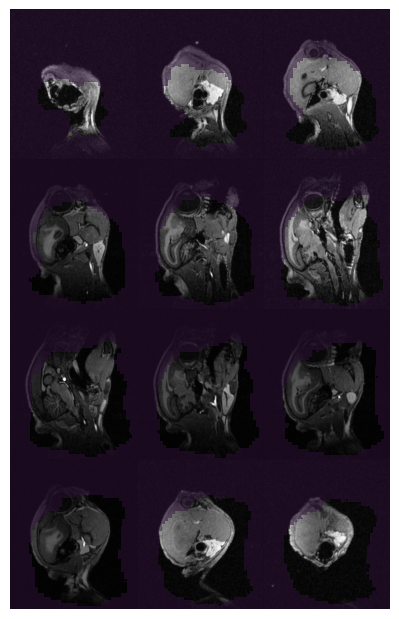

In [8]:
import ants
import antspynet

t1w_file = os.path.join(output_dir, 'Florian_preproc', 'T1w_MPR_averaged.nii.gz')
t1w_image = ants.image_read(t1w_file)

seg = antspynet.brain_extraction(t1w_image, modality="t1", verbose=True)
ants.plot(t1w_image, overlay=seg, overlay_alpha=0.5)

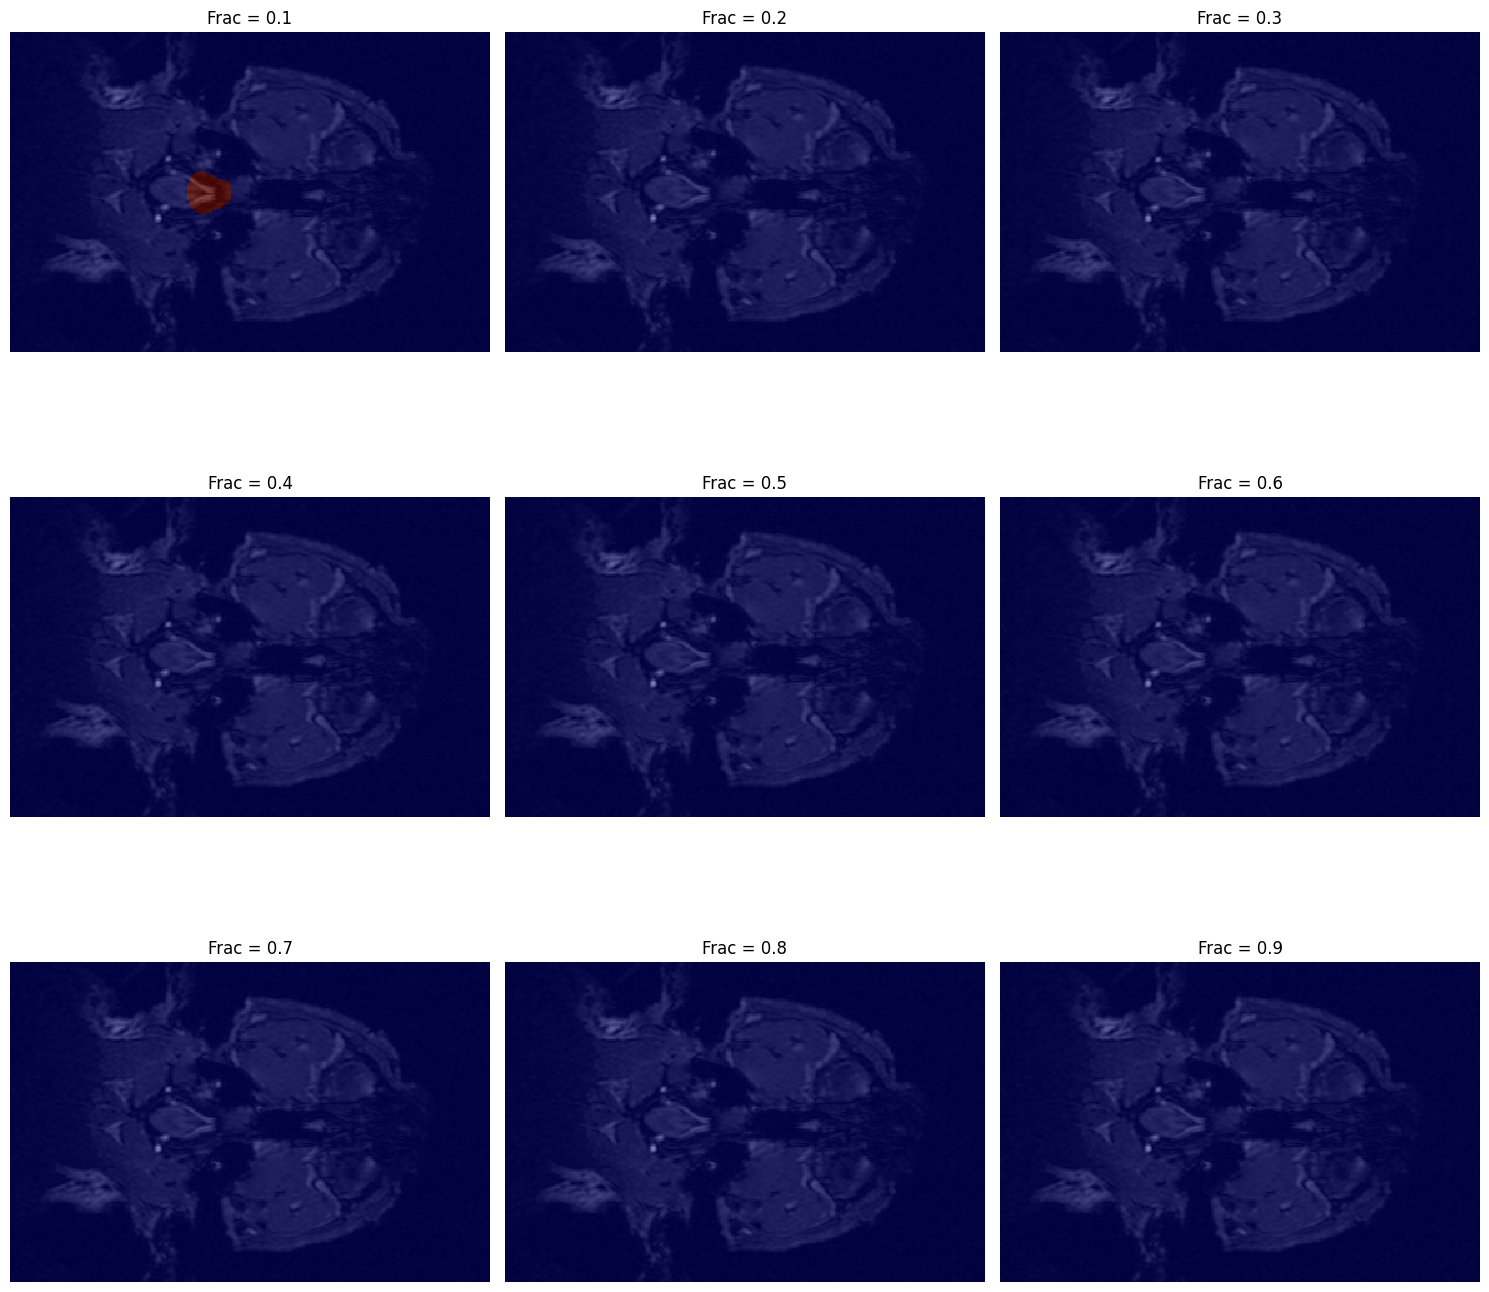

In [13]:
import os
import matplotlib.pyplot as plt
import nibabel as nib
from nipype.interfaces import fsl

def plot_image_and_mask(image_path, mask_path, ax):
    """Helper function to plot an image and overlay its mask."""
    image = nib.load(image_path).get_fdata()
    mask = nib.load(mask_path).get_fdata()
    
    ax.imshow(image[:, image.shape[1]//2, :], 'gray', interpolation='none')
    ax.imshow(mask[:, mask.shape[1]//2, :], 'jet', alpha=0.5, interpolation='none')  
    ax.axis('off')

# Input MRI file
in_file = os.path.join(output_dir, 'Florian_preproc', 'bias_corrected_brain.nii.gz')
# List of fractional intensity threshold values to test
frac_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Parameters for grid layout
n_images = len(frac_values)
n_cols = 3  # Number of images per row
n_rows = (n_images + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Set up the figure for plotting with multiple rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = np.array(axes).reshape(n_rows, n_cols)  # Ensure axes is a 2D array even if n_rows is 1

for i, frac in enumerate(frac_values):
    row = i // n_cols  # Row index
    col = i % n_cols  # Column index

    out_file = os.path.join(output_dir, 'Florian_preproc', 'bet3', f'brain_extracted_frac_{frac}.nii.gz')
    mask_file = os.path.join(output_dir, 'Florian_preproc', 'bet3', f'brain_extracted_frac_{frac}_mask.nii.gz')

    # Setup and run FSL BET with different frac values
    skullstrip = fsl.BET(in_file=in_file, out_file=out_file, mask=True, frac=frac)
    result = skullstrip.run()

    # Plotting
    plot_image_and_mask(in_file, mask_file, axes[row, col])
    axes[row, col].set_title(f'Frac = {frac}')

# Hide any unused axes if the number of frac_values isn't a multiple of n_cols
for ax in axes.flat[i+1:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

In [11]:
import ants
def create_spherical_mask(image, center, radius):
    # Create an empty image with the same shape as the input image
    mask = ants.make_image(image.shape, voxval=0, spacing=image.spacing)

    # Generate coordinates for a grid
    grid = np.ogrid[[slice(0, dim) for dim in image.shape]]
    # Calculate the distance from the center
    dist_from_center = sum((grid[dim] - center[dim])**2 for dim in range(len(image.shape)))
    # Create a spherical mask
    mask_array = dist_from_center <= radius**2
    mask.numpy()[:] = mask_array.astype(int)

    return mask

def skull_strip_marmoset_generic(image_path, template_path):
    # Load the brain image and the template
    image = ants.image_read(image_path)
    template = ants.image_read(template_path)
    
    # Calculate center of the image for each dimension
    center = tuple(dim // 2 for dim in image.shape)
    # Calculate the radius as a quarter of the minimum dimension of the image
    radius = min(image.shape) // 4
    
    # Generate a spherical mask
    mask = create_spherical_mask(image, center, radius)
    
    # Perform brain extraction using the generic mask
    brain_extracted = ants.brain_extraction(
        image, 
        template,
        probability_mask=mask,
        use_random_seeding=False,
        number_of_threads=4
    )
    
    # Save the brain extracted image
    ants.image_write(brain_extracted['brain'], 'extracted_brain_generic_mask.nii.gz')
    
    return brain_extracted['brain']

image_path = os.path.join(output_dir, 'Florian_preproc', 'T1w_MPR_averaged.nii.gz')
template_path = os.path.join(data_dir, 'template_T2w_brain.nii.gz')

# Run the skull stripping
extracted_brain = skull_strip_marmoset_generic(image_path, template_path)

# plot the brain and the original image
plt.imshow(extracted_brain.numpy()[:, :, extracted_brain.shape[2] // 2], cmap='gray')
plt.imshow(image.numpy()[:, :, image.shape[2] // 2], alpha=0.5, cmap='Reds')
plt.title('Brain Mask Overlaid on T1 Image')
plt.show()


AttributeError: module 'ants' has no attribute 'brain_extraction'

## Preproc TOF

### Skull strip

In [3]:
in_file = os.path.join(output_dir, 'Florian_preproc', 'bias_corrected_tof.nii.gz')
out_file = os.path.join(output_dir, 'Florian_preproc', 'skullstripped_tof.nii.gz')


# Setup FSL BET interface
skullstrip = fsl.BET(in_file=in_file, out_file=out_file, mask=True)
skullstrip.inputs.frac = 0.5  # Adjust this based on your data

# Run the BET command
result = skullstrip.run()

print(f"Output file: {result.outputs.out_file}")
print(f"Binary brain mask: {result.outputs.mask_file}")


Output file: /Users/yibeichen/Documents/GitHub/fUSi-workflow/output/Florian_preproc/skullstripped_tof.nii.gz
Binary brain mask: /Users/yibeichen/Documents/GitHub/fUSi-workflow/output/Florian_preproc/skullstripped_tof_mask.nii.gz


In [ ]:
import os
import matplotlib.pyplot as plt
import nibabel as nib
from nipype.interfaces import fsl

# Input MRI file
in_file = os.path.join(output_dir, 'Florian_preproc', 'bias_corrected_tof.nii.gz')
# List of fractional intensity threshold values to test
frac_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Parameters for grid layout
n_images = len(frac_values)
n_cols = 3  # Number of images per row
n_rows = (n_images + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Set up the figure for plotting with multiple rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = np.array(axes).reshape(n_rows, n_cols)  # Ensure axes is a 2D array even if n_rows is 1

for i, frac in enumerate(frac_values):
    row = i // n_cols  # Row index
    col = i % n_cols  # Column index

    out_file = os.path.join(output_dir, 'Florian_preproc', 'bet_tof', f'brain_extracted_frac_{frac}.nii.gz')
    mask_file = os.path.join(output_dir, 'Florian_preproc', 'bet_tof', f'brain_extracted_frac_{frac}_mask.nii.gz')

    # # Setup and run FSL BET with different frac values
    # skullstrip = fsl.BET(in_file=in_file, out_file=out_file, mask=True, frac=frac)
    # result = skullstrip.run()

    # Plotting
    plot_image_and_mask(in_file, mask_file, axes[row, col])
    axes[row, col].set_title(f'Frac = {frac}')

# Hide any unused axes if the number of frac_values isn't a multiple of n_cols
for ax in axes.flat[i+1:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

In [17]:
def plot_image_and_mask(image_path, mask_path, ax):
    """Helper function to plot an image and overlay its mask."""
    image = nib.load(image_path).get_fdata()
    mask = nib.load(mask_path).get_fdata()
    
    ax.imshow(image[:, image.shape[1]//2, :], 'gray', interpolation='none')
    ax.imshow(mask[:, mask.shape[1]//2, :], 'jet', alpha=0.5, interpolation='none')  
    ax.axis('off')

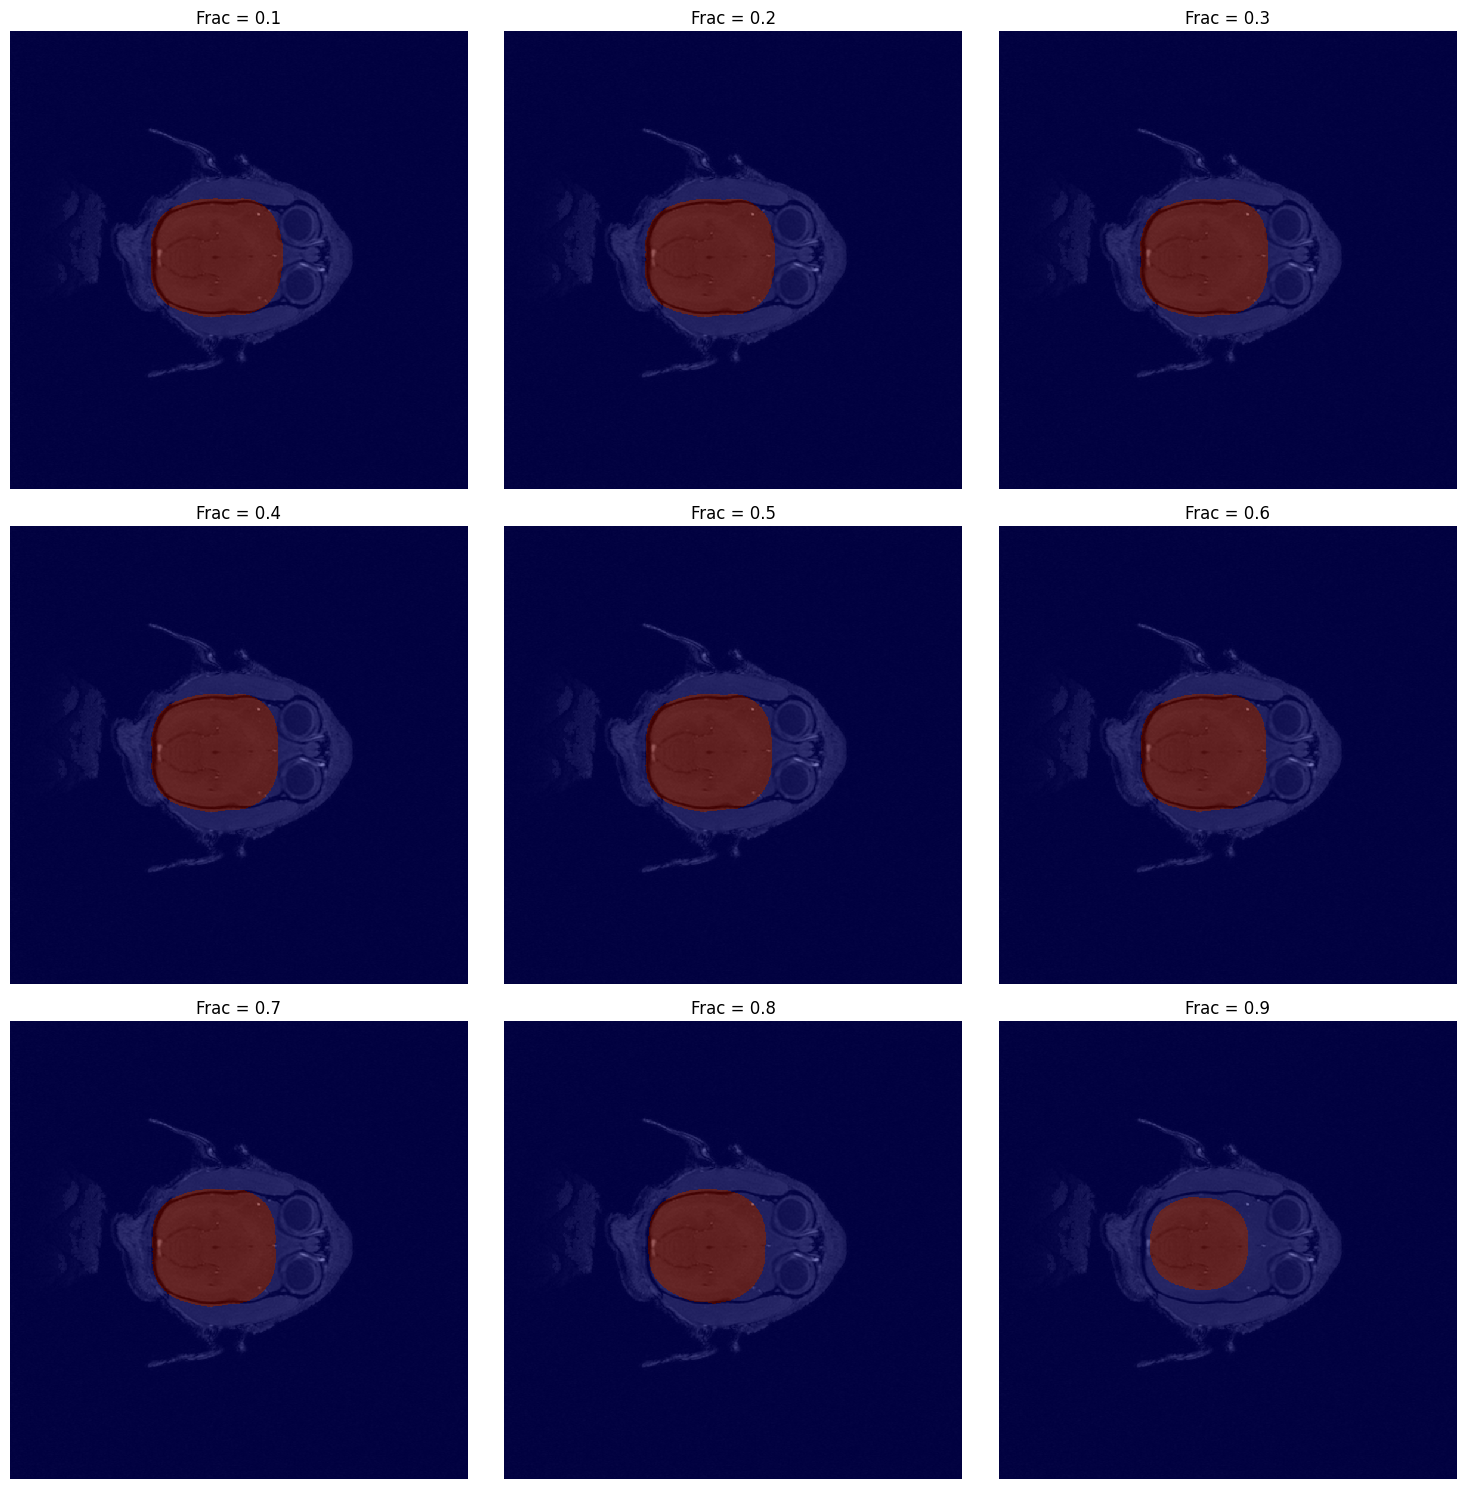

In [19]:
import os
import matplotlib.pyplot as plt
import nibabel as nib
from nipype.interfaces import fsl

# Input MRI file
in_file = os.path.join(output_dir, 'Florian_preproc', 'bias_corrected_tof.nii.gz')
# List of fractional intensity threshold values to test
frac_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Parameters for grid layout
n_images = len(frac_values)
n_cols = 3  # Number of images per row
n_rows = (n_images + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Set up the figure for plotting with multiple rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = np.array(axes).reshape(n_rows, n_cols)  # Ensure axes is a 2D array even if n_rows is 1

for i, frac in enumerate(frac_values):
    row = i // n_cols  # Row index
    col = i % n_cols  # Column index

    out_file = os.path.join(output_dir, 'Florian_preproc', 'bet_tof', f'brain_extracted_frac_{frac}.nii.gz')
    mask_file = os.path.join(output_dir, 'Florian_preproc', 'bet_tof', f'brain_extracted_frac_{frac}_mask.nii.gz')

    # # Setup and run FSL BET with different frac values
    # skullstrip = fsl.BET(in_file=in_file, out_file=out_file, mask=True, frac=frac)
    # result = skullstrip.run()

    # Plotting
    plot_image_and_mask(in_file, mask_file, axes[row, col])
    axes[row, col].set_title(f'Frac = {frac}')

# Hide any unused axes if the number of frac_values isn't a multiple of n_cols
for ax in axes.flat[i+1:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

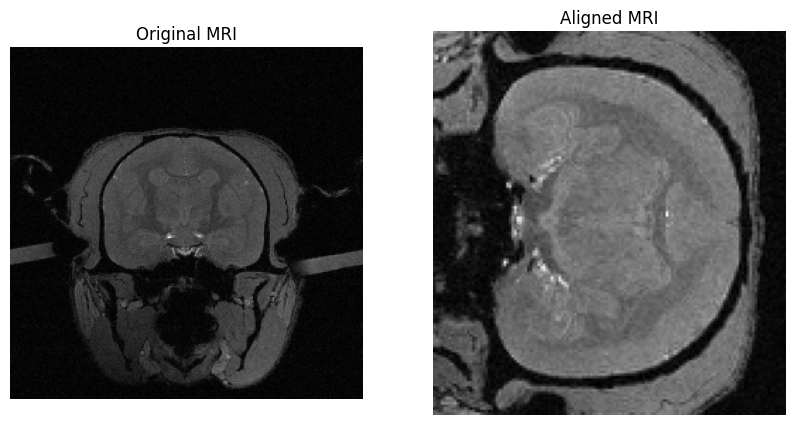

In [14]:
original_mri_file = "/Users/yibeichen/Desktop/alignment_chaoyi/original_MRI.nii.gz"
aligned_mri_file = "/Users/yibeichen/Desktop/alignment_chaoyi/aligned_MRI_to_atlas.nii.gz"

original_mri = ants.image_read(original_mri_file)
aligned_mri = ants.image_read(aligned_mri_file)

# Display the middle slice of the original MRI and the aligned MRI
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_mri.numpy()[:, original_mri.shape[1]//2, :], cmap='gray')
plt.title('Original MRI')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(aligned_mri.numpy()[:, aligned_mri.shape[1]//2, :], cmap='gray')
plt.title('Aligned MRI')
plt.axis('off')
plt.show()

In [15]:
original_mri.shape, aligned_mri.shape

((250, 250, 250), (147, 200, 135))

# 04/26/2024

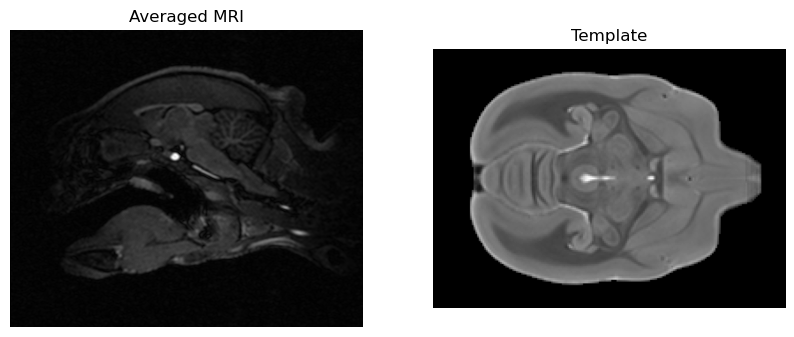

In [33]:
averaged_file1 = "/om/user/yibei/fUSi-workflow/data/Florian_raw_data/14 MEAN_S12_S13_1.nii"
template_file = "/om/user/yibei/fUSi-workflow/data/template_T2w_brain.nii.gz"

averaged1 = ants.image_read(averaged_file1)
template = ants.image_read(template_file)

# Display the middle slice of the original MRI and the aligned MRI
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(averaged1.numpy()[:, :, averaged1.shape[2]//2], cmap='gray')
plt.title('Averaged MRI')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(template.numpy()[:, :, template.shape[2]//2], cmap='gray')
plt.title('Template')
plt.axis('off')
plt.show()

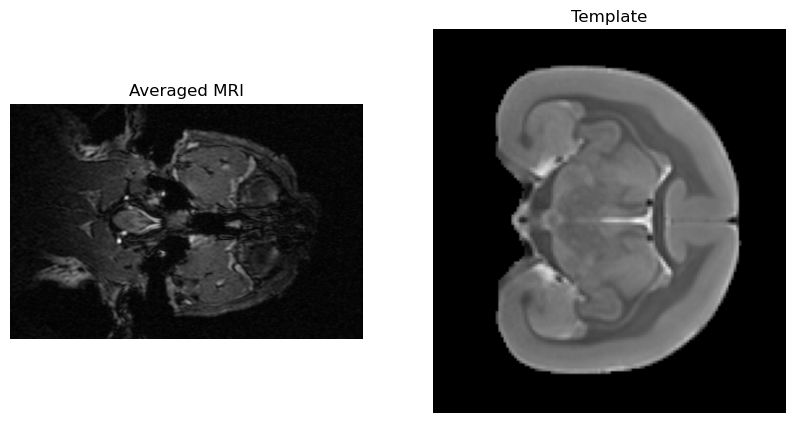

In [34]:
averaged_file2 = "/om/user/yibei/fUSi-workflow/output/Florian_preproc/T1w_MPR_averaged.nii.gz"
template_file = "/om/user/yibei/fUSi-workflow/data/template_T2w_brain.nii.gz"

averaged2 = ants.image_read(averaged_file2)
template = ants.image_read(template_file)

# Display the middle slice of the original MRI and the aligned MRI
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(averaged2.numpy()[:, averaged2.shape[1]//2, :], cmap='gray')
plt.title('Averaged MRI')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(template.numpy()[:, template.shape[1]//2, :], cmap='gray')
plt.title('Template')
plt.axis('off')
plt.show()

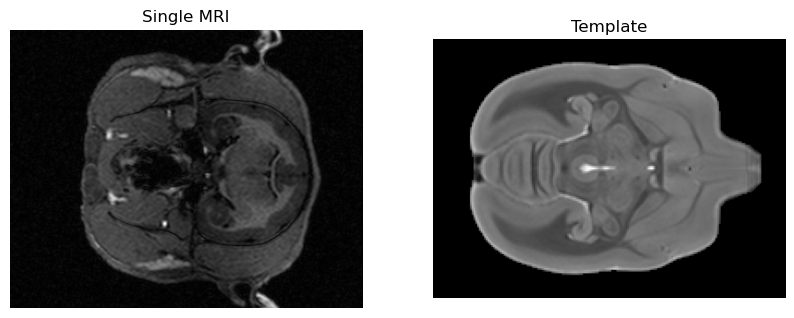

In [16]:
single_file = "/om/user/yibei/fUSi-workflow/output/Florian_MRI_nifti/T1w_MPR_20240405094408a.nii.gz"
template_file = "/om/user/yibei/fUSi-workflow/data/template_T2w_brain.nii.gz"

single = ants.image_read(single_file)
template = ants.image_read(template_file)

# Display the middle slice of the original MRI and the aligned MRI
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(single.numpy()[:, :, single.shape[2]//2], cmap='gray')
plt.title('Single MRI')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(template.numpy()[:, :, template.shape[2]//2], cmap='gray')
plt.title('Template')
plt.axis('off')
plt.show()

In [15]:
single.shape

(256, 324, 384)

In [35]:
averaged1.direction

array([[ 1.01375882e-01, -1.22808384e-01, -9.87239096e-01],
       [ 9.94848195e-01,  1.25142251e-02,  1.00600524e-01],
       [-5.43723725e-08, -9.92351498e-01,  1.23444323e-01]])

In [36]:
averaged2.direction

array([[-9.87239097e-01, -1.01375872e-01,  1.22808384e-01],
       [ 1.00600514e-01, -9.94848196e-01, -1.25142238e-02],
       [ 1.23444324e-01,  5.48320929e-08,  9.92351498e-01]])

In [29]:
single.direction

array([[-9.87239095e-01, -1.01375880e-01,  1.22808374e-01],
       [ 1.00600521e-01, -9.94848195e-01, -1.25142238e-02],
       [ 1.23444333e-01,  5.44153165e-08,  9.92351499e-01]])

In [19]:
template.direction

array([[-1.,  0.,  0.],
       [ 0., -1.,  0.],
       [ 0.,  0.,  1.]])

In [28]:
averaged.orientation

'LPI'

In [31]:
single.orientation

'LPI'

In [25]:
template.orientation

'LPI'

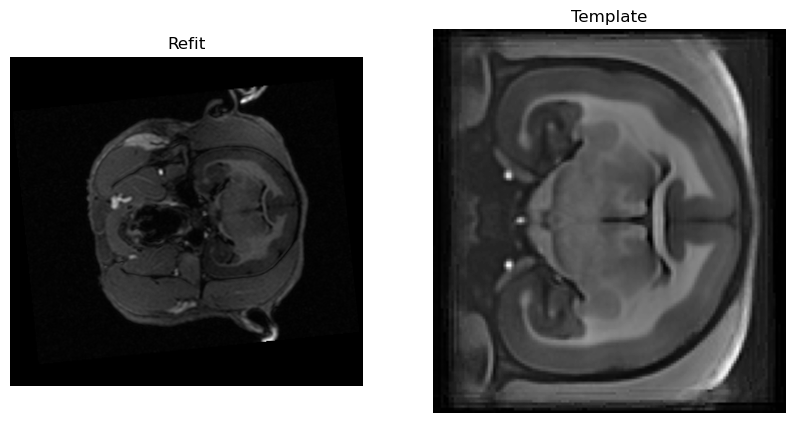

In [5]:
refit_file = "/om/user/yibei/fUSi-workflow/output/Florian_preproc/afni/reorient_mri/anat_raw.deo.ryf.rf.rs.nii.gz"
template_file = "/om/user/yibei/fUSi-workflow/data/template_T1w.nii.gz"

refit = ants.image_read(refit_file)
template = ants.image_read(template_file)

# Display the middle slice of the original MRI and the aligned MRI
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(refit.numpy()[:, refit.shape[1]//2, :], cmap='gray')
plt.title('Refit')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(template.numpy()[:, template.shape[1]//2, :], cmap='gray')
plt.title('Template')
plt.axis('off')
plt.show()

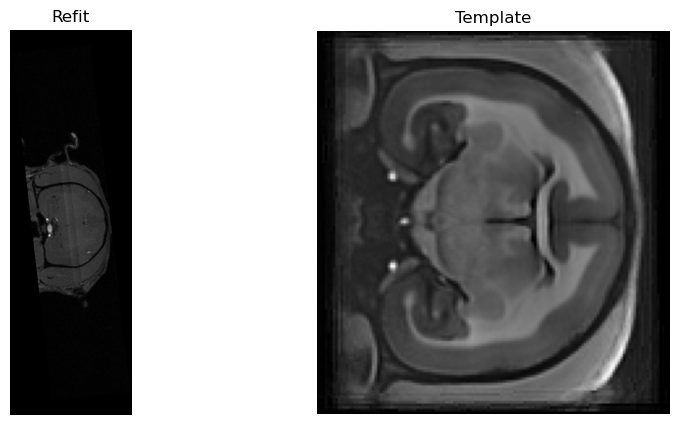

In [2]:
refit_file = "/om/user/yibei/fUSi-workflow/output/Florian_preproc/afni/reorient_angio/angio_raw_deo_ryf_rf_rs.nii.gz"
template_file = "/om/user/yibei/fUSi-workflow/data/template_T1w.nii.gz"

refit = ants.image_read(refit_file)
template = ants.image_read(template_file)

# Display the middle slice of the original MRI and the aligned MRI
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(refit.numpy()[:, refit.shape[1]//2, :], cmap='gray')
plt.title('Refit')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(template.numpy()[:, template.shape[1]//2, :], cmap='gray')
plt.title('Template')
plt.axis('off')
plt.show()

In [3]:
refit.direction, template.direction

(array([[-1.,  0.,  0.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  1.]]),
 array([[-1.,  0.,  0.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  1.]]))

In [4]:
refit.orientation, template.orientation

('LPI', 'LPI')

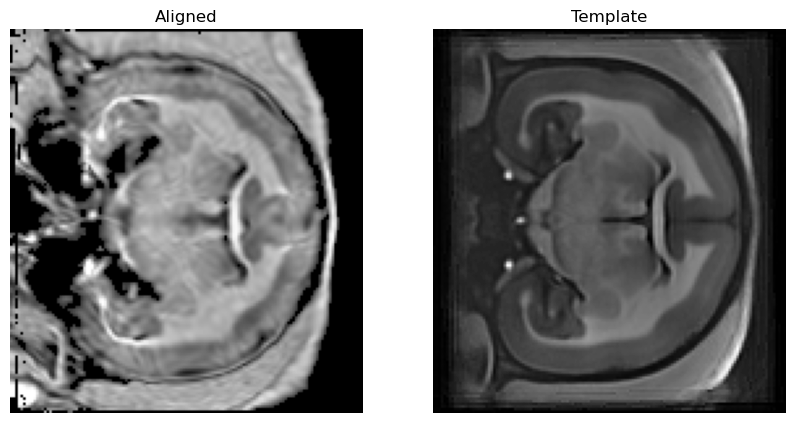

In [15]:
aligned_file = "/om/user/yibei/fUSi-workflow/output/Florian_preproc/afni/aw_results/anat_refit_warp2std_nsu.nii.gz"
template_file = "/om/user/yibei/fUSi-workflow/data/template_T1w.nii.gz"

aligned = ants.image_read(aligned_file)
template = ants.image_read(template_file)

# Display the middle slice of the original MRI and the aligned MRI
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(aligned.numpy()[:, aligned.shape[1]//2, :], cmap='gray')
plt.title('Aligned')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(template.numpy()[:, template.shape[1]//2, :], cmap='gray')
plt.title('Template')
plt.axis('off')
plt.show()

In [13]:
aligned.shape, template.shape

((147, 200, 135), (147, 200, 135))

# 04/29/2024

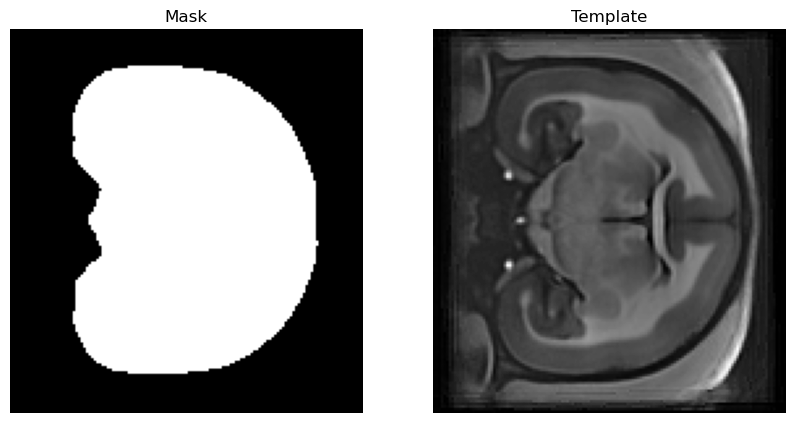

In [8]:
mask_file = "/om/user/yibei/fUSi-workflow/data/mask_brain.nii.gz"
template_file = "/om/user/yibei/fUSi-workflow/data/template_T1w.nii.gz"

mask = ants.image_read(mask_file)
template = ants.image_read(template_file)

# Display the middle slice of the original MRI and the aligned MRI
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(mask.numpy()[:, mask.shape[1]//2, :], cmap='gray')
plt.title('Mask')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(template.numpy()[:, template.shape[1]//2, :], cmap='gray')
plt.title('Template')
plt.axis('off')
plt.show()

In [9]:
mask.shape

(147, 200, 135)

In [10]:
template.shape

(147, 200, 135)